# <h1 align='center'><b><font color='indianred'></p>MultiLabel Classification Dense Embeddings </b></h1>

In [1]:
!nvidia-smi

Sun Sep 24 16:20:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.cpu_count()

8

# <Font color = 'indianred'>**Load Libraries/Install Software**

In [3]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext --upgrade -qq
    !pip install torchmetrics -qq
    !pip install torchinfo -qq

    basepath = '/content/drive/MyDrive'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.2 MB/s eta 0:00:00


In [4]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
from torchinfo import summary

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np
import pandas as pd

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from types import SimpleNamespace
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt

# <Font color = 'indianred'>**Specify Project Folders**

In [5]:
# Convert the base path to a Path object
base_folder = Path(basepath)

# Define the data folder path
data_folder = base_folder/'data'
custom_functions = base_folder/'custom_functions'
model_folder = base_folder/'models'
model_folder.mkdir(exist_ok=True)

#  <Font color = 'indianred'>**Data Preparation**

##  <Font color = 'indianred'>**Load df_multilabel_hw_cleaned files using joblib**

In [6]:
df_multilabel_hw_cleaned = data_folder/'df_multilabel_cleaned.joblib'

In [7]:
df = joblib.load(df_multilabel_hw_cleaned)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47427 entries, 0 to 47426
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  47427 non-null  object
 1   Tags          47427 non-null  object
 2   Tag_Number    47427 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [9]:
df.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [10]:
type(df['Tag_Number'][0][0])

str

In [11]:
import ast

df['Tag_Number'] = df['Tag_Number'].apply(lambda x: ast.literal_eval(x))
type(df['Tag_Number'][0][0])

int

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
labels = ['c#','java','php','javascript','android','jquery','c++','python','iphone','asp.net']
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Tag_Number'])

In [13]:
# create a dataframe just to verify the one hot encoding
df1 = pd.DataFrame(y,columns = labels)

In [14]:
df = pd.concat([df,df1],axis=1)

In [15]:
df

,cleaned_text,Tags,Tag_Number,c#,java,php,javascript,android,jquery,c++,python,iphone,asp.net
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]",1,0,0,0,0,0,0,0,0,1
1,run javascript code server java code want run ...,java javascript,"[1, 3]",0,1,0,1,0,0,0,0,0,0
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]",1,0,0,0,0,0,0,0,0,1
3,run python script php server run nginx web ser...,php python,"[2, 7]",0,0,1,0,0,0,0,1,0,0
4,advice write function m try write function res...,javascript jquery,"[3, 5]",0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47423,listen phone state application nee liste phone...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47424,android ui thread thread task want access main...,java android,"[1, 4]",0,1,0,0,1,0,0,0,0,0
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]",0,0,0,1,0,0,0,0,0,1


In [16]:
from sklearn.model_selection import train_test_split

X = df['cleaned_text'].values
y = y.astype(float)

X_temp, X_test, y_temp, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_temp,y_temp,test_size = 0.25, random_state=100)

In [18]:
print(f'X: {X.size} y: {y.shape}')
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_valid: {X_valid.shape} y_valid: {y_valid.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X: 47427 y: (47427, 10)
X_train: (28455,) y_train: (28455, 10)
X_valid: (9486,) y_valid: (9486, 10)
X_test: (9486,) y_test: (9486, 10)


In [19]:
print(f"Train set: {X_train.size/X.size *100 :.2f}%")
print(f"Valid set: {X_valid.size/X.size * 100 :.2f}%")
print(f"Test set: {X_test.size/X.size *100 :.2f}%")

Train set: 60.00%
Valid set: 20.00%
Test set: 20.00%


## <Font color = 'indianred'>**Custom Dataset Class**

In [20]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading cleaned texts and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Converting the feature data to a NumPy array for consistency
        self.X = np.array(X)

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [21]:
trainset = CustomDataset(X_train, y_train)
validset = CustomDataset(X_valid, y_valid)
testset = CustomDataset(X_test, y_test)

In [22]:
trainset[1][1]

'php use header location load new page entire window jquery tab use jquery tab tab form form submit reload action database tab page reload form link payment page pay check submit payment page load current page close use header location entire page load tab want ho use header location tab load payment page entire window php javascript check vallidation'

In [23]:
trainset[1][0]

array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])

## <Font color = 'indianred'>**Create Vocab**

In [24]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (l_, text) in dataset:
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab


In [25]:
se_vocab = get_vocab(trainset, min_freq=2)

In [26]:
len(se_vocab)

90122

In [27]:
se_vocab.get_itos()[0:8]

['<unk>', 'include', 'code', 'file', '.cs', 'write', 'web', 'form']

## <Font color = 'indianred'>**Collate_fn for Data Loaders**

In [28]:
# Creating a function that will be used to get the indices of words from vocab
def text_pipeline(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(x).split()]

In [29]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.float)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [text_pipeline(text, my_vocab) for text in texts]

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # Concatenate all text indices into a single tensor
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    return (texts, offsets), labels

## <Font color = 'indianred'>**Check Data Loaders**

Let us check if our collate function is working by creating a dataloader

In [30]:
batch_size = 1
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=partial(collate_batch, my_vocab = se_vocab),
                                           )

In [31]:
torch.manual_seed(22)
for (text, offset), label in check_loader:
    print(text, offset, label)
    break


tensor([    5,     0,  5414,   400,   384,   224,   916,   530,  4734,   853,
          946,    16,  2127,   916, 14629,   979,  5414,   384,   381,    80,
          701, 41304,  3975,   916,  2114]) tensor([0]) tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


<ipython-input-29-f27edb0c2513>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels, dtype=torch.float)


# <Font color = 'indianred'>**Model**
EmbeddingBag → Hidden_Layer1 →ReLU  → Dropout_Layer1 → BatchNorn_Layer1 → Hidden_Layer2 → ReLU  → DropoutLayer2 → BatchNorm_Layer2  → Output Layer

In [32]:
class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):

        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.BatchNorm1d(num_features=output_dim)

        )
    def forward(self, x):
      return self.layers(x)


## <Font color = 'indianred'>**Model with EmbeddingBag layer**

In [33]:
class CustomMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.layers = nn.Sequential(
            CustomBlock(embedding_dim , hidden_dim1, drop_prob1),
            CustomBlock(hidden_dim1, hidden_dim2, drop_prob2),
            nn.Linear(hidden_dim2, num_outputs)
        )

    def forward(self, input_tuple):
        data, offsets = input_tuple
        embed_out = self.embedding_bag(data, offsets)
        out = self.layers(embed_out)

        return out

In [34]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
model_embedding_2 = CustomMLP(vocab_size=len(se_vocab) , embedding_dim=300, hidden_dim1=200, hidden_dim2=100, drop_prob1=0.5, drop_prob2=0.5, num_outputs=10)

# Move the model to the device
model_embedding_2 = model_embedding_2.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model_embedding_2, input_data=[(data, offsets)], device=device, depth =4)


Layer (type:depth-idx)                   Output Shape              Param #
CustomMLP                                [3, 10]                   --
├─EmbeddingBag: 1-1                      [3, 300]                  27,036,600
├─Sequential: 1-2                        [3, 10]                   --
│    └─CustomBlock: 2-1                  [3, 200]                  --
│    │    └─Sequential: 3-1              [3, 200]                  --
│    │    │    └─Linear: 4-1             [3, 200]                  60,200
│    │    │    └─ReLU: 4-2               [3, 200]                  --
│    │    │    └─Dropout: 4-3            [3, 200]                  --
│    │    │    └─BatchNorm1d: 4-4        [3, 200]                  400
│    └─CustomBlock: 2-2                  [3, 100]                  --
│    │    └─Sequential: 3-2              [3, 100]                  --
│    │    │    └─Linear: 4-5             [3, 100]                  20,100
│    │    │    └─ReLU: 4-6               [3, 100]                  -

In [35]:
# Test the model
# Move the model to the device
model_embedding_2 = model_embedding_2.to(device)

# Generate some dummy input data and offsets, and move them to the device
# we will pass text as input, collate function will create data and offsets
data = torch.LongTensor([1, 2, 4, 5, 4]).to(device)
offsets = torch.LongTensor([0, 2, 4]).to(device)

# Since nn.Sequential expects a single input, we pack data and offsets into a tuple
output = model_embedding_2((data, offsets))

print(output)

tensor([[ 0.3673,  0.0800, -0.6208, -0.1175, -0.4952, -0.5870,  0.1908, -0.0294,
          0.9973, -0.4653],
        [ 0.0588, -0.2914,  0.7951,  0.1104,  0.2846,  0.2063,  0.0277,  0.4092,
         -0.3537,  1.0368],
        [-0.5380,  0.1477, -0.0212, -0.0283, -0.0517,  0.2367, -0.4454, -0.5464,
         -0.4959, -0.4135]], device='cuda:0', grad_fn=<AddmmBackward0>)


# <Font color = 'indianred'>**Model Training Functions**




## <Font color = 'indianred'>**Step Function**

In [36]:
from torchmetrics import HammingDistance

In [37]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2: Calculate the number of correctly classified samples
    # predicted = torch.argmax(outputs.data, 1)
    predicted = outputs>=0
    # correct = torch.sum(predicted == targets)

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients before the optimizer step
        nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
        # Update parameters
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, predicted
    else:
        return outputs, predicted


## <Font color = 'indianred'>**Train_Epoch Function**

In [38]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    # running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, predicted = step(inputs, targets, model, device, loss_function, optimizer)
        targets = targets.to(device)
        # Update running loss and correct predictions counter
        running_train_loss += loss.item()
        # running_train_correct += correct
        train_hamming_distance.update(predicted, targets)

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    # train_acc = running_train_correct / len(train_loader.dataset)
    # Compute Hamming Distance for the epoch
    epoch_hamming_distance = train_hamming_distance.compute()
    train_hamming_distance.reset()

    return train_loss, epoch_hamming_distance.item()


## <Font color = 'indianred'>**Val_Epoch Function**

In [39]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    # running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, predicted = step(inputs, targets, model, device, loss_function, optimizer=None)
            targets = targets.to(device)
            # Update running loss and correct predictions counter
            running_val_loss += loss.item()
            # running_train_correct += correct
            train_hamming_distance.update(predicted, targets)

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    epoch_hamming_distance = train_hamming_distance.compute()
    train_hamming_distance.reset()

    return val_loss, epoch_hamming_distance.item()


## <Font color = 'indianred'>**Train Function**

In [40]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_hamming_distance_history (list): History of training hamming_distance for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_hamming_distance_history (list): History of validation hamming_distance for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_hamming_distance_history = []
    valid_hamming_distance_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_hamming_distance = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_hamming_distance = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_hamming_distance_history.append(train_hamming_distance)
        valid_loss_history.append(valid_loss)
        valid_hamming_distance_history.append(valid_hamming_distance)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train hamming_distance: {train_hamming_distance:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid hamming_distance: {valid_hamming_distance:.4f}")
        print()

    return train_loss_history, train_hamming_distance_history, valid_loss_history, valid_hamming_distance_history


# <Font color = 'indianred'>**Hyperparameters**

In [41]:
hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(se_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    DROP_PROB1=0.5,
    DROP_PROB2=0.5,
    NUM_OUTPUTS=10,

    # training
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE = 'value',
    CLIP_VALUE =10,
    PATIENCE = 5
)

# <Font color = 'indianred'>**Training Configuration**

In [42]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

collate_fn = partial(collate_batch, my_vocab=se_vocab)

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=hyperparameters.BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=hyperparameters.BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn,  num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=hyperparameters.BATCH_SIZE,   shuffle=False,
                                          collate_fn=collate_fn,  num_workers=4)

# cross entropy loss function
loss_function = nn.BCEWithLogitsLoss()

# model
model_se = CustomMLP(vocab_size=hyperparameters.VOCAB_SIZE,
                       embedding_dim=hyperparameters.EMBED_DIM,
                       hidden_dim1=hyperparameters.HIDDEN_DIM1,
                       hidden_dim2=hyperparameters.HIDDEN_DIM2,
                       drop_prob1=hyperparameters.DROP_PROB1,
                       drop_prob2=hyperparameters.DROP_PROB2,
                       num_outputs=hyperparameters.NUM_OUTPUTS)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_se.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.AdamW(model_se.parameters(),
                             lr=hyperparameters.LEARNING_RATE,

                             )

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# <Font color = 'indianred'>**Sanity Check**
- Check the loss without any training. For Cross entropy the expected value will be log(number of classes)

In [43]:
for input_ , targets  in train_loader:

    # move inputs and outputs to GPUs
    model_se = model_se.to(device)

    input_ = tuple(input_tensor.to(device)
                            for input_tensor in input_)
    targets = targets.to(device)

    model_se.eval()
    # Forward pass
    output = model_se(input_)
    loss = loss_function(output, targets)
    print(f'Actual loss: {loss}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.6761412024497986
Expected Theoretical loss: 0.6931471805599453


# <Font color = 'indianred'>**Training Model**

In [44]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc = train(
    train_loader, valid_loader, model_se, optimizer, loss_function, hyperparameters.EPOCHS, device
)


Epoch 1/5
Train Loss: 0.4885 | Train hamming_distance: 0.2327
Valid Loss: 0.2060 | Valid hamming_distance: 0.0704

Epoch 2/5
Train Loss: 0.2065 | Train hamming_distance: 0.0746
Valid Loss: 0.1540 | Valid hamming_distance: 0.0559

Epoch 3/5
Train Loss: 0.1627 | Train hamming_distance: 0.0580
Valid Loss: 0.1361 | Valid hamming_distance: 0.0499

Epoch 4/5
Train Loss: 0.1391 | Train hamming_distance: 0.0496
Valid Loss: 0.1243 | Valid hamming_distance: 0.0461

Epoch 5/5
Train Loss: 0.1237 | Train hamming_distance: 0.0443
Valid Loss: 0.1170 | Valid hamming_distance: 0.0434



# <Font color = 'indianred'>**Plot Losses Metrics**


In [56]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")
    if val_losses:
        plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot training and validation metrics (if available)
    if train_metrics[0] is not None:
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")
        if val_metrics:
            plt.plot(epochs, val_metrics, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Metric: Hamming Distance")
        plt.legend()
        plt.show()


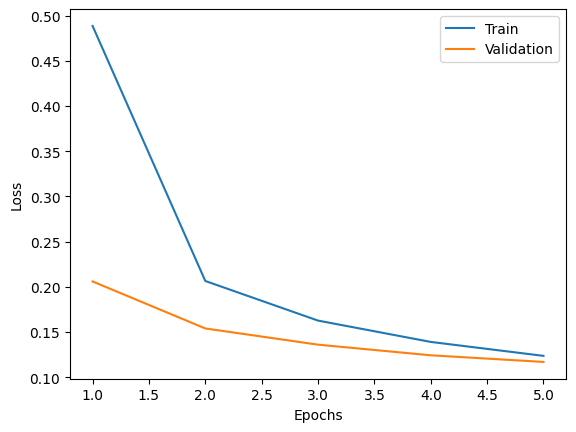

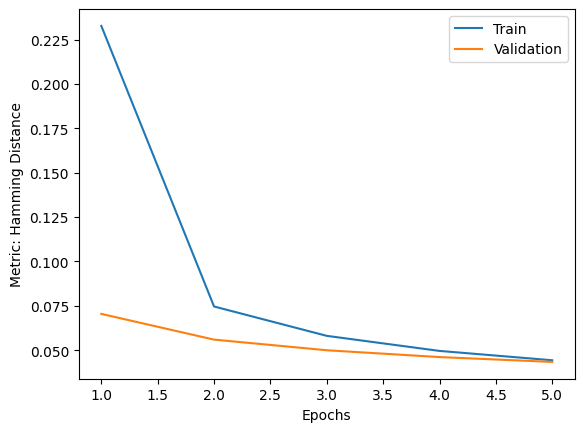

In [57]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

# <Font color = 'indianred'>**Get Accuracy, Predictions**

In [47]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            _, predicted = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)
            targets = targets.to(device)
            # Choose the label with maximum probability
            train_hamming_distance.update(predicted, targets)

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))

    # Calculate accuracy by comparing the predicted and actual labels
    epoch_hamming_distance = train_hamming_distance.compute()
    train_hamming_distance.reset()

    # Return tuple containing predictions and accuracy
    return predictions, epoch_hamming_distance.item()

In [48]:
# Get the prediction and accuracy
predictions_test, acc_test = get_acc_pred(test_loader, model_se, device)
predictions_train, acc_train = get_acc_pred(train_loader, model_se, device)
predictions_valid, acc_valid = get_acc_pred(valid_loader, model_se, device)

In [49]:
# Print Test Accuracy
print('Test hamming distance', acc_test )
print('Train hamming distance', acc_train )
print('Valid hamming distance', acc_valid )

Test hamming distance 0.043432414531707764
Train hamming distance 0.03241610527038574
Valid hamming distance 0.04335862398147583
